In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy.special import voigt_profile
from scipy.stats import norm

In [8]:
# Function to make histograms
def make_dist(data,num_bins,label,title,filename,log=False,weights=None):
    if weights is None:
        weights = np.ones(len(data))
    fig,ax = plt.subplots()
    ax.hist(data,bins=num_bins,weights=weights)#,density=True)
    if log:
        ax.set_yscale('log',nonpositive='clip')
    ax.set_title(title)
    ax.set_xlabel(label)
    #ax.set_ylabel('density')
    ax.set_ylabel('Count')
    textstr = '\n'.join((r'$\mu=%.2f$' % (np.mean(data), ),
        r'$\mathrm{median}=%.2f$' % (np.median(data), ),
        r'$\sigma=%.2f$' % (np.std(data), ),
        r'$\mathrm{count}=%.0f$' % (len(data), ) ))
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    ax.text(0.95, 0.95, textstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', horizontalalignment='right',
            bbox=props)
    #ax.figure.savefig(filename)
    #plt.close(fig)
    plt.show()

In [3]:
# Exponential distribution
def dist_exponential(x, lam, const):
    f = np.exp(-lam*(x+const))
    return f

In [4]:
# Parameters
seed = 123
min_M = 50
max_M = 110
min_iso = 0
max_iso = 10
count = 100000
num_cones = 18

# Invariant mass distribution parameters, taken from CMS fits
voigt_mass = 90.84412107971114
voigt_gamma = 1.698056352839003
voigt_sigma = 0.8933245062591034
exp_lambda = 0.027783519828575538
exp_const = 80.94869759922919

# Isolation distribution parameters
sig_gauss_mean = 3
sig_gauss_std = 0.5
bg_gauss_mean = 6
bg_gauss_std = 1

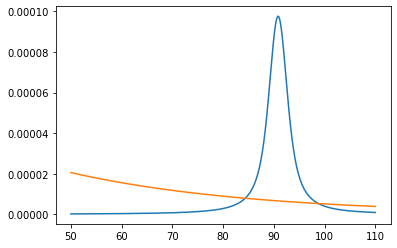

In [18]:
# Draw signal M from voigt (gaussian + breit wigner conv.), background
# from exponential
uniform_M = np.linspace(min_M, max_M, count)
voigt = voigt_profile(uniform_M - voigt_mass, voigt_sigma, voigt_gamma)
exp = dist_exponential(uniform_M, exp_lambda, exp_const)
voigt_pmf = voigt / np.sum(voigt)
exp_pmf = exp / np.sum(exp)
plt.plot(uniform_M, voigt_pmf)
plt.plot(uniform_M, exp_pmf)

In [16]:
np.random.seed(seed+1)
sig_Ms = np.random.choice(uniform_M, size=count, p=voigt_pmf)
np.random.seed(seed+2)
bg_Ms = np.random.choice(uniform_M, size=count, p=exp_pmf)
print('Signal Ms')
print(sig_Ms)
print('Background Ms')
print(bg_Ms)

Signal Ms
[86.18756188 92.52662527 91.24441244 ... 83.61593616 92.12222122
 91.53301533]
Background Ms
[69.05499055 51.7196172  75.60825608 ... 64.87414874 67.03237032
 53.799838  ]


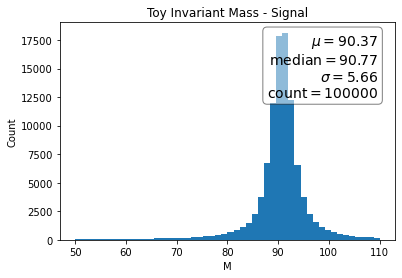

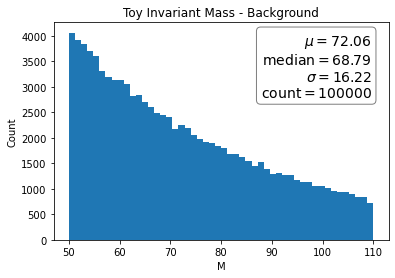

In [10]:
make_dist(sig_Ms, 50, 'M', 'Toy Invariant Mass - Signal',
        'toy_invariant_mass_sig.png')
make_dist(bg_Ms, 50, 'M', 'Toy Invariant Mass - Background',
        'toy_invariant_mass_bg.png')

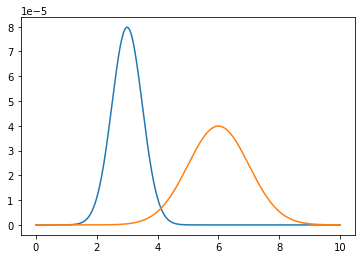

In [19]:
# Draw isos from gaussians
uniform_iso = np.linspace(min_iso, max_iso, count)
sig_gauss = norm(loc=sig_gauss_mean, scale=sig_gauss_std)
bg_gauss = norm(loc=bg_gauss_mean, scale=bg_gauss_std)
sig_gauss_pmf = sig_gauss.pdf(uniform_iso) /\
        np.sum(sig_gauss.pdf(uniform_iso))
bg_gauss_pmf = bg_gauss.pdf(uniform_iso) /\
        np.sum(bg_gauss.pdf(uniform_iso))
plt.plot(uniform_iso, sig_gauss_pmf)
plt.plot(uniform_iso, bg_gauss_pmf)

In [20]:

# Make largest isos first
sig_isos = np.zeros((count,num_cones))
bg_isos = np.zeros((count,num_cones))
np.random.seed(seed+1)
sig_isos[:,-1] = np.random.choice(uniform_iso, size=count, p=sig_gauss_pmf)
np.random.seed(seed+2)
bg_isos[:,-1] = np.random.choice(uniform_iso, size=count, p=bg_gauss_pmf)

# Make smaller isos
for i in range(count):
    np.random.seed(seed+i)

    # Real data is sparse so sometimes adjacent cones are the same, so
    # create flag to check if a cone shouldn't change
    subtract_flags = np.random.uniform(size=(num_cones-1)*2) < 0.8
    subtract_flags = subtract_flags.reshape((num_cones-1),2)

    for j,sub in zip(np.flip(np.arange(num_cones-1)), subtract_flags):
        # Calculate signal iso

        # Calculate the next smallest iso by subtracting some portion of
        # the largest one off
        np.random.seed(seed+i)
        new_iso = sig_isos[i][j+1] - \
                np.random.uniform(high=2/num_cones)*sig_isos[i][-1]

        # Check flag to see if this cone should remain the same
        if sub[0]:

            # If everything is subtracted away before reaching the
            # smallest cone, all smaller cones should be 0 (happens
            # frequently in real data that first few cones are 0)
            if new_iso >= 0:
                sig_isos[i][j] = new_iso
            else:
                sig_isos[i][j] = 0
        else:
            sig_isos[i][j] = sig_isos[i][j+1]

        # Calculate bg iso
        np.random.seed(seed+i)
        new_iso = bg_isos[i][j+1] - \
                np.random.uniform(high=2/num_cones)*bg_isos[i][-1]

        if sub[1]:
            if new_iso >= 0 and sub[1]:
                bg_isos[i][j] = new_iso
            else:
                bg_isos[i][j] = 0
        else:
            bg_isos[i][j] = bg_isos[i][j+1]

In [21]:
print('Signal Isos')
print(sig_isos[:10])
print('Background Isos')
print(bg_isos[:10])

Signal Isos
[[0.         0.         0.         0.         0.16959445 0.3534719
  0.53734934 0.72122678 0.90510422 1.08898167 1.27285911 1.45673655
  1.64061399 1.82449143 1.82449143 2.00836888 2.19224632 2.37612376]
 [2.70220392 2.74144951 2.7806951  2.7806951  2.81994068 2.85918627
  2.89843185 2.93767744 2.97692303 3.01616861 3.0554142  3.09465978
  3.13390537 3.17315096 3.21239654 3.25164213 3.29088772 3.3301333 ]
 [1.00265566 1.17669527 1.35073487 1.52477447 1.52477447 1.69881408
  1.69881408 1.69881408 1.87285368 2.04689329 2.04689329 2.04689329
  2.22093289 2.39497249 2.5690121  2.7430517  2.91709131 3.09113091]
 [2.43086623 2.46531045 2.49975467 2.49975467 2.53419888 2.5686431
  2.60308731 2.63753153 2.67197575 2.70641996 2.74086418 2.77530839
  2.77530839 2.80975261 2.84419683 2.87864104 2.91308526 2.94752948]
 [0.36222696 0.52830707 0.52830707 0.69438717 0.86046728 1.02654738
  1.19262749 1.35870759 1.5247877  1.6908678  1.85694791 2.02302801
  2.02302801 2.18910812 2.35518822

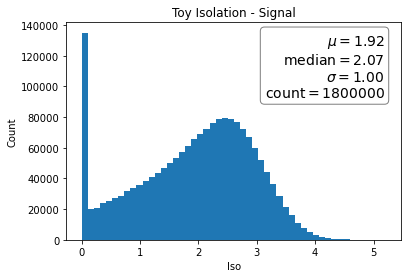

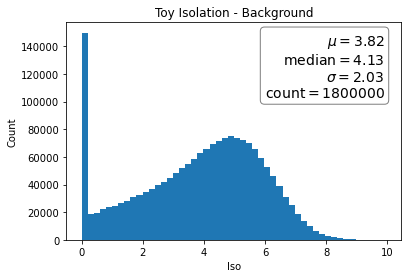

In [22]:
make_dist(sig_isos.ravel(), 50, 'Iso', 'Toy Isolation - Signal',
        'toy_isolation_sig.png')
make_dist(bg_isos.ravel(), 50, 'Iso', 'Toy Isolation - Background',
        'toy_isolation_bg.png')

In [23]:
# Save data
np.save('toy_Ms.npy', np.concatenate([sig_Ms, bg_Ms]))
np.save('toy_isos.npy', np.concatenate([sig_isos, bg_isos]))
np.save('toy_labels.npy', np.concatenate([
    np.ones(len(sig_isos)), np.zeros(len(bg_isos))]))